In [1]:
import numpy as np #работа с массивами
import pandas as pd # работа с данными
import matplotlib.pyplot as plt #визуализация данных
import seaborn as sns #тоже самое

import warnings #фильтр чтобы не выводились ошибки
warnings.filterwarnings('ignore')

import tensorflow as tf #библиотека для машинного обучение и глубокого обучение
from tensorflow.keras import layers, models #испорт модуля layers, models из keras
from tensorflow.keras.callbacks import ModelCheckpoint #импортирует модуль из керас кэлбэк Модел чекпоин, для сохранение 

# As the daataset is divided into folders
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
w,h = 400,400 # Здесь ширина изображений 400х400 будет
batch_size = 32 #за одну итерацию будет 32 изображений обрабатываться

train_path = "C:/Users/77081/Code/predict_pneumonia/model/datasets/train" #путь к каталогу трэйн
test_path = "C:/Users/77081/Code/predict_pneumonia/model/datasets/test" #путь к каталогу тест
val_path = "C:/Users/77081/Code/predict_pneumonia/model/datasets/val" #путь к каталогу вал

train_img_gen = ImageDataGenerator( #используется для аугментаций (предобработки изображение)
    rescale = 1.0/255,
    zoom_range=0.3 #случайным образом увеличивает изображение на 30%
)

test_img_gen = ImageDataGenerator(#используется для аугментаций (предобработки изображение)
    rescale = 1.0/255
)

val_img_gen = ImageDataGenerator(#используется для аугментаций или предобработки изображение
    rescale = 1.0/255 # нормализует значения пикселей к диапазону [0,1] 
)

train_dataset = train_img_gen.flow_from_directory( #потоки данных из тренировочной
    train_path,
    target_size = (w,h),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True
)

test_dataset = test_img_gen.flow_from_directory(#потоки данных из тестовой
    test_path,
    target_size = (w,h),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False
)

val_dataset = val_img_gen.flow_from_directory( #потоки данных из вала) 
    val_path, #переменна пути к валу
    target_size = (w,h), #две переменные размер 400х400
    batch_size = batch_size, #переменная итерация будет 32 изображение за раз
    class_mode = 'categorical', #в качестве меток используется one hot encoding
    shuffle = False #данные в валидационном остануться в том же порядке
)

Found 11624 images belonging to 3 classes.
Found 1022 images belonging to 3 classes.
Found 943 images belonging to 3 classes.


In [3]:
train_dataset.class_indices #представляет словарь из чего состоит

{'NORMAL': 0, 'PNEUMONIA': 1, 'TURBERCULOSIS': 2}

(32, 400, 400, 3)


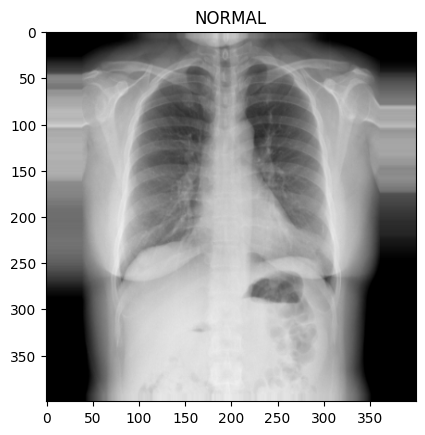

(32, 400, 400, 3)


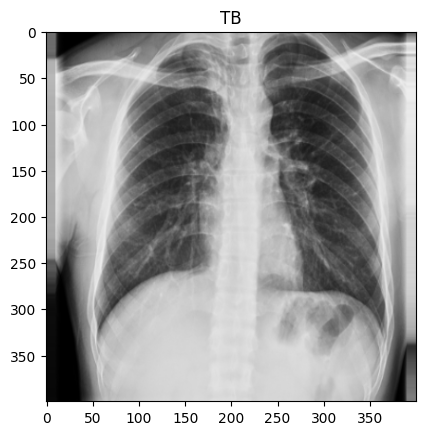

(32, 400, 400, 3)


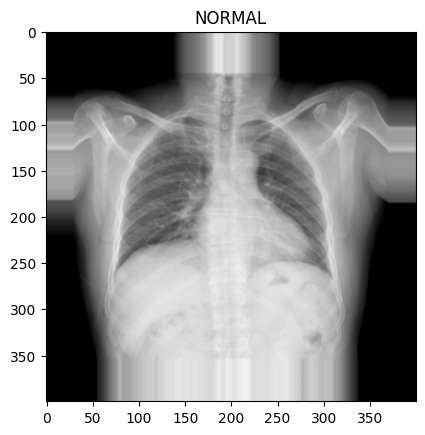

(32, 400, 400, 3)


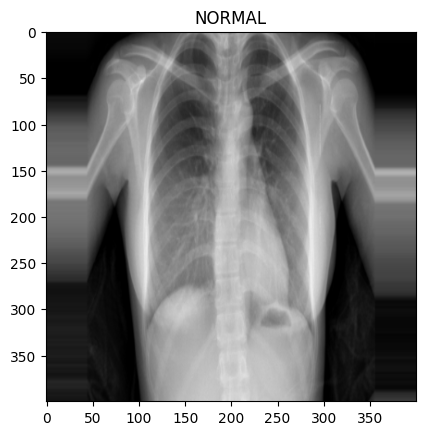

(32, 400, 400, 3)


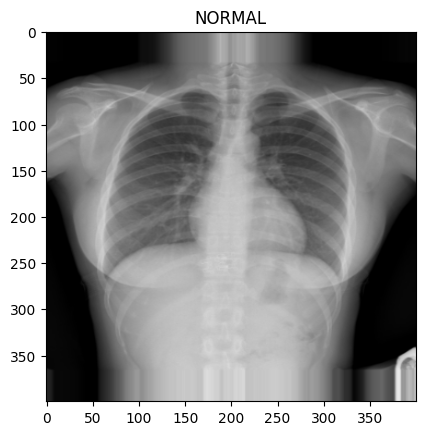

In [4]:
classes = ['NORMAL','PNEUMONIA','TB'] # создает список классов

for _ in range(5):#цикл количество вывода картинок 5
    img,label = train_dataset.next() #img это массив изображений а label массив меток.
    print(img.shape) #размерность картинки
    plt.title(classes[np.argmax(label[0])]) #устанавливает заглавную метку по индексу
    plt.imshow(img[0]) #отображает первую картинку
    plt.show() #показ фото

In [5]:
train_dataset.image_shape #размер картинки

(400, 400, 3)

In [6]:
model = models.Sequential() #создание пустой модели к которой можно будет добавлять слои
#добавляет сверточный слой с 64 фильтрами и размер ядра 3x3
model.add(layers.Conv2D(64,(3,3), activation = 'relu', input_shape=(w,h,3))) 
#слой с размером пула 2х2 он уменьшает улавливая ключевые признаки
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation ='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2))) #повторяет эти шаги 3 раза для того чтобы была иерархия изображении

model.add(layers.Flatten()) #слой выравнивания, преоброзование в одномерный массив

model.add(layers.Dense(128, activation ='relu')) # добавляет полносвязный слой с 128 нейронами
model.add(layers.Dropout(0.5)) #добавляет слой отсева с коэфицентом 0.5, это помогает предотвратить переобучение 
model.add(layers.Dense(3,activation='softmax')) # Добавляет полносвязный слой с 4 нейронами (по числу классов) 
#компилирует модель, используя оптимизатор Adam, функцию потерь categorical_crossentropy
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy']) 
#Выводит краткое описание архитектуры модели, включая количество параметров и форму данных на каждом слое.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 398, 398, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 199, 199, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 197, 197, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 98, 98, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 48, 48, 128)      0

In [7]:
resnetModel = models.Sequential() #создает новую модель нейронной сети

ResNet_101_V2 = tf.keras.applications.ResNet101V2( #Создает экземпляр предварительно обученной архитектуры ResNet-101V2 из библиотеки TensorFlow.
                include_top = False, #слой не должен включаться в модел
                weights='imagenet', #загружает веса, обученные на наборе данных ImageNet.
                input_shape=(w,h,3),# устанавливает размер входных изображений
                pooling='max', #использует слой пулинга с максимальным объединением для уменьшения размерности данных.
                classes=3 #указывает количествbо классов в вашей задаче классификации (в данном случае, 4 класса).
            )
#Замораживает веса всех слоев в предварительно обученной ResNet-101V2
for layer in ResNet_101_V2.layers:
    layer.trainable = False
    
resnetModel.add(ResNet_101_V2) #Добавляет предварительно обученную ResNet-101V2
resnetModel.add(layers.Flatten()) #обавляет слой выравнивания (преобразования в одномерный массив)
resnetModel.add(layers.Dense(512, activation='relu')) #Добавляет полносвязный слой с 512 нейронами и функцией активации ReLU.
resnetModel.add(layers.Dense(3, activation='softmax')) #Добавляет полносвязный слой с 4 нейронами (по числу классов) 

resnetModel.compile(optimizer ='adam',loss='categorical_crossentropy',metrics=['accuracy']) #Компилирует модель, используя оптимизатор Adam

resnetModel.summary() #Выводит краткое описание 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 2048)              42626560  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dense_3 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 43,677,187
Trainable params: 1,050,627
Non-trainable params: 42,626,560
_________________________________________________________________


In [8]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
#пути, где будут сохраняться веса модели. В данном случае, это папка datasets.
weight_path = "C:/Users/77081/Code/predict_pneumonia/model/datasets/"


#Создает объект ModelCheckpoint, который будет использоваться в процессе обучения модели 
model_checkpoint = ModelCheckpoint(
    filepath= weight_path,       #Указывает путь для сохранения весов модели. В данном случае, в папке datasets.
    save_best_only = True,    #Этот параметр говорит о том, что будут сохранены только лучшие (максимальные) 
    save_weights_only =True,      #Сохраняет только веса модели, без сохранения самой модели.
    mode ="max",           #Указывает, что мы хотим максимизировать мониторинговую метрику.
    monitor = 'val_accuracy'    #Указывает метрику, которую нужно максимизировать
)
    

In [10]:
history = resnetModel.fit(train_dataset,epochs=10,validation_data=val_dataset,callbacks=[model_checkpoint])

'''Этот код обучает модель resnetModel на данных из train_dataset в течение 10 эпох, 
используя данные из val_dataset для валидации. 
Обратный вызов model_checkpoint сохраняет лучшие веса модели в папке datasets. 
Информация о процессе обучения сохраняется в объекте history.'''

Epoch 1/10
364/364 [==============================] - 400s 1s/step - loss: 1.2529 - accuracy: 0.8384 - val_loss: 0.4268 - val_accuracy: 0.8643
Epoch 2/10
364/364 [==============================] - 318s 873ms/step - loss: 0.2747 - accuracy: 0.8971 - val_loss: 0.3001 - val_accuracy: 0.8855
Epoch 3/10
364/364 [==============================] - 322s 884ms/step - loss: 0.2357 - accuracy: 0.9087 - val_loss: 0.2669 - val_accuracy: 0.8971
Epoch 4/10
364/364 [==============================] - 321s 882ms/step - loss: 0.2172 - accuracy: 0.9180 - val_loss: 0.3321 - val_accuracy: 0.8791
Epoch 5/10
364/364 [==============================] - 320s 878ms/step - loss: 0.1980 - accuracy: 0.9246 - val_loss: 0.4542 - val_accuracy: 0.8367
Epoch 6/10
364/364 [==============================] - 318s 872ms/step - loss: 0.1876 - accuracy: 0.9296 - val_loss: 0.6074 - val_accuracy: 0.7784
Epoch 7/10
364/364 [==============================] - 316s 867ms/step - loss: 0.1889 - accuracy: 0.9288 - val_loss: 0.2548 - va

'Этот код обучает модель resnetModel на данных из train_dataset в течение 10 эпох, \nиспользуя данные из val_dataset для валидации. \nОбратный вызов model_checkpoint сохраняет лучшие веса модели в папке datasets. \nИнформация о процессе обучения сохраняется в объекте history.'

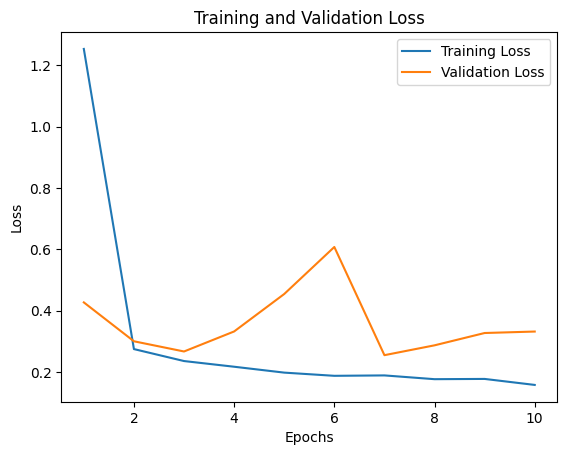

In [11]:
#для построения графика функции потерь 
loss = history.history['loss'] #Извлекает значения функции потерь на тренировочном наборе из истории обучения.
val_loss = history.history['val_loss'] # Извлекает значения функции потерь на валидационном наборе из истории обучения.
epochs = len(history.history['loss']) #Определяет количество эпох, для которых была проведена тренировкa.
# Plot the loss and val_loss
epochs_range = range(1, epochs + 1) #Создает диапазон эпох для оси X графика.
plt.plot(epochs_range, loss, label='Training Loss') #Строит график функции потерь на тренировочном наборе данных.
plt.plot(epochs_range, val_loss, label='Validation Loss') #Строит график функции потерь на валидационном наборе данных.
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [13]:
resnetModel.load_weights(weight_path)

# make predictions
predictions = resnetModel.predict(test_dataset)
predictions

32/32 [==============================] - 20s 571ms/step


array([[2.2953774e-01, 1.8056079e-06, 7.7046043e-01],
       [4.2584881e-01, 2.6046686e-04, 5.7389069e-01],
       [9.8605794e-01, 5.4721072e-06, 1.3936546e-02],
       ...,
       [5.5267126e-03, 5.2136756e-03, 9.8925960e-01],
       [2.0637734e-02, 1.8047908e-02, 9.6131438e-01],
       [2.8454530e-01, 9.3187531e-03, 7.0613593e-01]], dtype=float32)

In [14]:
predicted_class = np.argmax(predictions, axis=1)

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       590
           1       0.86      0.95      0.90       277
           2       0.94      0.75      0.84       155

    accuracy                           0.90      1022
   macro avg       0.90      0.87      0.89      1022
weighted avg       0.91      0.90      0.90      1022

{'NORMAL': 0, 'PNEUMONIA': 1, 'TURBERCULOSIS': 2}


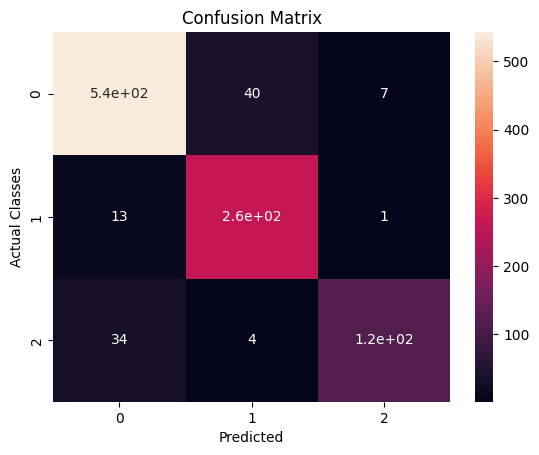

In [15]:
from sklearn.metrics import confusion_matrix, classification_report

true_labels = test_dataset.classes

sns.heatmap(confusion_matrix(true_labels, predicted_class), annot=True)

# Print classification report
print(classification_report(true_labels, predicted_class))
print(test_dataset.class_indices)

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual Classes')
plt.show()

In [16]:
import json

# Ваш словарь class_dict
class_dict = {'NORMAL': 0, 'PNEUMONIA': 1, 'TB': 2}

# Сохранение словаря в файл JSON
with open("class_dictionary.json", "w") as json_file:
    json.dump(class_dict, json_file)


1/1 [==============================] - 1s 1s/step
Predicted class: TB


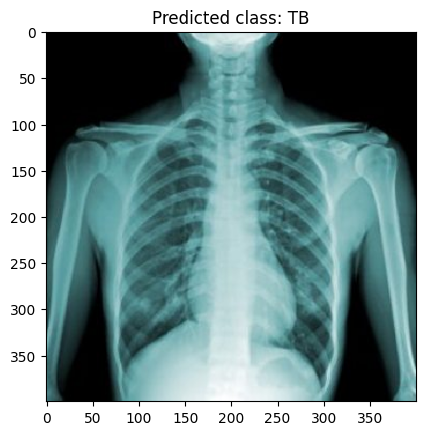

In [17]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt


def classify_image(image_path):
    
    # Загрузка изображения и предобработка
    img = image.load_img(image_path, target_size=(w, h))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  

    # Получение предсказания от модели
    prediction = resnetModel.predict(img_array)

    # Преобразование предсказания в метку класса
    predicted_class = classes[np.argmax(prediction)]

    # Вывод результата
    print("Predicted class:", predicted_class)

    # Отображение изображения
    plt.imshow(img)
    plt.title("Predicted class: " + predicted_class)
    plt.show()

# Пример использования
image_path_to_check = r"C:\Users\77081\Code\predict_pneumonia\test_images\4c3752b8f56da52c4da3ba29783311d2.jpg"
classify_image(image_path_to_check)


1/1 [==============================] - 0s 27ms/step
NORMAL: 7.07%
PNEUMONIA: 2.00%
TB: 90.92%
Predicted class: TB


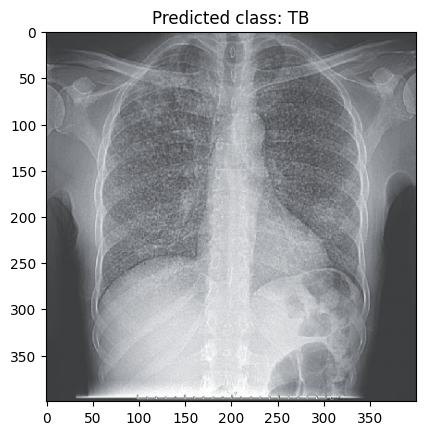

In [26]:
def classify_image(image_path, classes, model):
    # Загрузка изображения и предобработка
    img = image.load_img(image_path, target_size=(w, h))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  

    # Получение предсказания от модели
    prediction = model.predict(img_array)

    # Преобразование предсказания в метку класса
    predicted_class = classes[np.argmax(prediction)]

    # Получение вероятностей для каждого класса
    probabilities = prediction[0]
    
    # Вывод вероятностей предсказаний для каждого класса
    for i, prob in enumerate(probabilities):
        print(f"{classes[i]}: {prob * 100:.2f}%")

    # Вывод результата
    print("Predicted class:", predicted_class)

    # Отображение изображения
    plt.imshow(img)
    plt.title("Predicted class: " + predicted_class)
    plt.show()

image_path_to_check = r"C:\Users\77081\Code\predict_pneumonia\test_images\tuber.jpg"
classify_image(image_path_to_check, classes, resnetModel)


In [17]:
resnetModel.save(r"C:\Users\77081\Code\predict_pneumonia\my_model.h5")

In [3]:
# Загрузка модели из файла .h5
loaded_model = tf.keras.models.load_model("my_model.h5")


1/1 [==============================] - 0s 198ms/step
Predicted class: TB
NORMAL: 3.12%
PNEUMONIA: 0.24%
TB: 96.64%


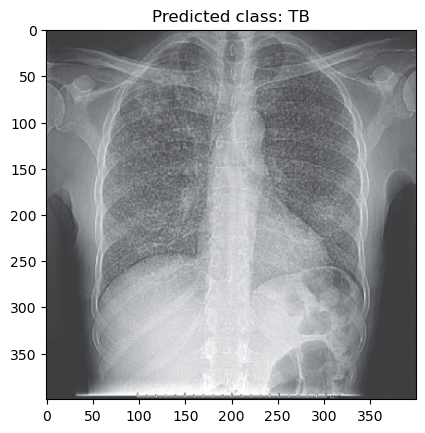

In [23]:
# Функция для классификации изображения с отображением вероятностей классов
def classify_image(image_path):
    
    # Загрузка изображения и предобработка
    img = image.load_img(image_path, target_size=(w, h))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  

    # Получение предсказания от модели
    prediction = loaded_model.predict(img_array)

    # Преобразование предсказания в метку класса
    predicted_class_index = np.argmax(prediction)
    predicted_class = classes[predicted_class_index]

    # Получение вероятности предсказания для каждого класса
    probabilities = prediction[0]
    class_probabilities = {classes[i]: probabilities[i] * 100 for i in range(len(classes))}

    # Вывод результата с вероятностями
    print("Predicted class:", predicted_class)
    for class_name, probability in class_probabilities.items():
        print(f"{class_name}: {probability:.2f}%")

    # Отображение изображения
    plt.imshow(img)
    plt.title("Predicted class: " + predicted_class)
    plt.show()

# Пример использования
image_path_to_check = r"C:\Users\77081\Code\predict_pneumonia\model\datasets\test_images\tuber.jpg"  # Путь к вашему изображению
classify_image(image_path_to_check)
